In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from foolbox.utils import imagenet_example

from cleverhans.attacks import FastGradientMethod
from cleverhans.utils_keras import KerasModelWrapper

from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.applications import ResNet50
from keras import backend as K

Using TensorFlow backend.


In [2]:
kmodel = VGG16()
img, label = imagenet_example()

In [3]:
img1 = np.expand_dims(preprocess_input(img.copy()), axis=0)
img1.shape

(1, 224, 224, 3)

In [4]:
decode_predictions(kmodel.predict(img1))

[[('n02123045', 'tabby', 0.1791926),
  ('n02123159', 'tiger_cat', 0.11803333),
  ('n02124075', 'Egyptian_cat', 0.10345929),
  ('n02971356', 'carton', 0.06272861),
  ('n02127052', 'lynx', 0.03703218)]]

In [6]:
# tabby 281
# tiger cat 282

def grad_cam(label):
    class_output = kmodel.output[:, label]
    last_conv_layer = kmodel.get_layer('block5_conv3')
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    #print('Pooled grads:', pooled_grads.shape[0])
    iterate = K.function([kmodel.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img1])

    for i in range(pooled_grads.shape[0]): # 512
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    return heatmap

heatmap = grad_cam(281)

Pooled grads: 512


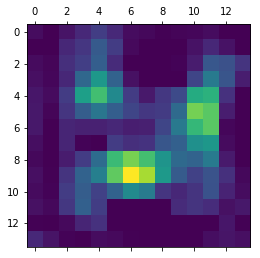

In [6]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [7]:
heatmap = cv2.resize(heatmap, (224, 224))

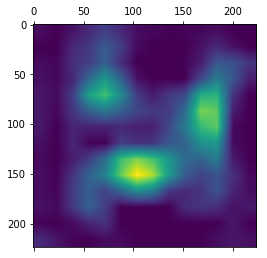

In [8]:
plt.matshow(heatmap)

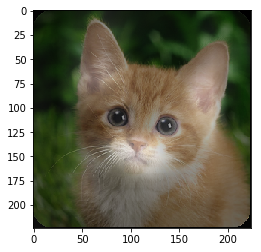

In [9]:
plt.imshow(img.astype(int))
plt.imshow(heatmap, alpha=0.5, cmap='gray')

In [ ]:
# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

superimposed_img

In [10]:
kmodel2 = ResNet50()
model = KerasModelWrapper(kmodel2)
K.set_learning_phase(0)
sess = K.get_session()

In [11]:
img2 = img[:, :, ::-1].copy()
img2 = np.expand_dims(img2, axis=0)

In [12]:
decode_predictions(kmodel2.predict(img2))

[[('n02123159', 'tiger_cat', 0.29198417),
  ('n02127052', 'lynx', 0.2608814),
  ('n02123045', 'tabby', 0.16957559),
  ('n02124075', 'Egyptian_cat', 0.09674287),
  ('n02123394', 'Persian_cat', 0.045101654)]]

In [13]:
img2_min = img2.min()
img2_max = img2.max()

fgsm = FastGradientMethod(model, sess=sess)
# adv_target[0, 340] = 1
fgsm_params = {'eps': 10,
               'clip_min': img2_min,
               'clip_max': img2_max}

In [14]:
adv = fgsm.generate_np(img2, **fgsm_params)
decode_predictions(kmodel.predict(adv))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



[[('n02971356', 'carton', 0.14138144),
  ('n02124075', 'Egyptian_cat', 0.11515548),
  ('n02123394', 'Persian_cat', 0.103265375),
  ('n02127052', 'lynx', 0.0892289),
  ('n02123045', 'tabby', 0.07750596)]]

In [15]:
np.argmax(kmodel.predict(adv))

478

In [16]:
heatmap2 = grad_cam(478)

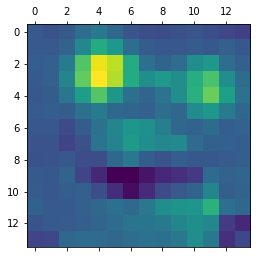

In [17]:
plt.matshow(heatmap2)

In [18]:
heatmap2 = cv2.resize(heatmap2, (224, 224))

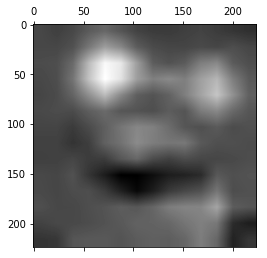

In [19]:
plt.matshow(heatmap2, cmap='gray')

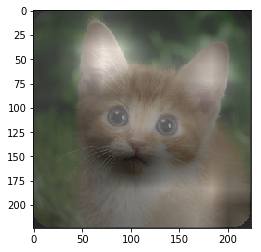

In [20]:
plt.imshow(img.astype(int))
plt.imshow(heatmap2, alpha=0.75, cmap='gray')